# Assignment 3.2

# Sequence classification model

In [1]:
from __future__ import print_function

## 1. Preprocess data

#### Tasks:

* Create word vocabulary index (use 10.000 most frequent words)
* Preprocess training and validation set for model input. Use vocabulary index as lookup dictionary to transform raw text into integer sequences. You may use code from Practical 5.

In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = "data_part2"
EMBEDDINGS_PATH = "embeddings_part2"
MODEL_PATH = "models_part2"
VALID_DATA_SIZE = 600
MAX_REVIEW_LENGTH = 600

In [4]:
# function to clean raw text data

def striphtml(html):
    p = re.compile(r'<.*?>')
    return p.sub('', html)

def clean(s):
    return re.sub(r'[^\x00-\x7f]', r'', s)

In [5]:
complete_train_data = pd.read_csv(os.path.join(DATA_PATH,"trainingData.tsv"), header=0, delimiter="\t")

In [6]:
complete_valid_data = pd.read_csv(os.path.join(DATA_PATH,"validationData.tsv"), header=0, delimiter="\t")

In [7]:
print(type(complete_valid_data))
print(complete_train_data.shape)
print(complete_valid_data.shape)


<class 'pandas.core.frame.DataFrame'>
(25000, 3)
(25000, 2)


In [8]:
## Maybe need to change this values for randomized versions
#train_data = complete_train_data[].sample(frac=0.8)
#valid_data = complete_valid_data.sample(frac=0.2)
train_data = complete_train_data[:20000]
valid_data = complete_valid_data[:5000]
unseen_valid_data = complete_valid_data[5000:10000]
test_data = complete_valid_data[10000:15000]
print(len(train_data))
print(len(valid_data))
print(len(unseen_valid_data))
print(len(test_data))

20000
5000
5000
5000


## Clean training, validation, unseen validation, and test sets

In [9]:

train_docs = []
train_labels = []
for cont, sentiment in zip(train_data.review, train_data.sentiment):
    
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    train_docs.append(doc)
    train_labels.append(sentiment)
    
# this  will create a cleaned version of validation set
# we also need to extract labels from attribute 'id'

valid_docs =[]
valid_labels = []
i=0
for docid,cont in zip(valid_data.id, valid_data.review):
    
    id_label = docid.split('_')
    # if rating >= 7, then assign 1 (positive sentiment) as label
    if(int(id_label[1]) >= 7):
        valid_labels.append(1)
    # else, assign 0 (negative sentiment) as label
    else:
        valid_labels.append(0)         
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    valid_docs.append(doc)
    
unseen_valid_docs = []
unseen_valid_labels = []
i = 0
for docid,cont in zip(unseen_valid_data.id, unseen_valid_data.review):
    
    id_label = docid.split('_')
    # if rating >= 7, then assign 1 (positive sentiment) as label
    if(int(id_label[1]) >= 7):
        unseen_valid_labels.append(1)
    # else, assign 0 (negative sentiment) as label
    else:
        unseen_valid_labels.append(0)         
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    unseen_valid_docs.append(doc)

    
test_docs = []
test_labels = []
i = 0
for docid,cont in zip(test_data.id, test_data.review):
    
    id_label = docid.split('_')
    # if rating >= 7, then assign 1 (positive sentiment) as label
    if(int(id_label[1]) >= 7):
        test_labels.append(1)
    # else, assign 0 (negative sentiment) as label
    else:
        test_labels.append(0)         
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    test_docs.append(doc)

In [10]:
print("Length of train docs: {}, length of train labels: {}".format(len(train_docs), len(train_labels)))
print("Length of validation docs: {}, length of validation labels: {}".format(len(valid_docs), len(valid_labels)))
print("Length of unseen validation docs: {}, length of unseen validation labels: {}".format(len(unseen_valid_docs), 
                                                                                            len(unseen_valid_labels)))
print("Length of test docs: {}, length of test labels: {}".format(len(test_docs), len(test_labels)))


Length of train docs: 20000, length of train labels: 20000
Length of validation docs: 5000, length of validation labels: 5000
Length of unseen validation docs: 5000, length of unseen validation labels: 5000
Length of test docs: 5000, length of test labels: 5000


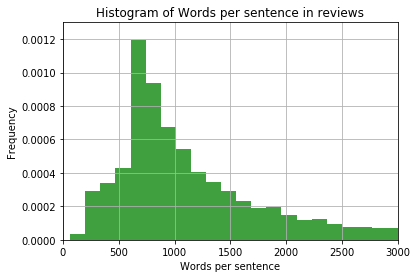

In [11]:
word_freq_train_docs = np.array([len(word) for word in train_docs])
nbins = 100
plt.hist(word_freq_train_docs, nbins, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Words per sentence')
plt.ylabel('Frequency')
plt.title('Histogram of Words per sentence in reviews')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 3000, 0, 0.0013])
plt.grid(True)
plt.show()


### Max review length selection

From the distribution of number of words per sentence shown in the histogram above, we observe that most of the sentences have 500 or more words. In our experiments we tried 500, 600, and 700 words per sentence as the maximum number of words per review (MAX_REVIEW_LENGTH). For 600 words per sentence we obtained better performance.

## Create vocabulary index

In [12]:
# FUNCTION to tokenize documents into array list of words
# you may also use nltk tokenizer, sklearn tokenizer, or keras tokenizer - 
# but for the tutorial in text modeling, we will use below function: 

def tokenizeWords(text):
    
    ## any sequence of non alphanumerical characters is replaced by a space
    tokens = re.sub(r"[^a-z0-9]+", " ", text.lower()).split()
    return [str(strtokens) for strtokens in tokens]

# FUNCTION to create word-level vocabulary index

def indexingVocabulary(array_of_words):

    wordIndex = list(array_of_words)
    
    # we will later pad our sequence into fixed length, so
    # we will use '0' as the integer index of pad 
    wordIndex.insert(0,'<pad>')
    
    # index for word token '<start>' as a starting sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<start>')
    
    # index for word token '<end>' as an ending sign of sequence. We won't use it for this model
    # but for the latter model (sequence-to-sequence model)
    wordIndex.append('<end>')
    
    # index for word token '<unk>' or unknown words (out of vocabulary words) 
    wordIndex.append('<unk>')
    
    vocab=dict([(i,wordIndex[i]) for i in range(len(wordIndex))])
    
    return vocab

In [13]:
# tokenize text from training set

train_str_tokens = []
all_tokens = []
for i, text in enumerate(train_docs):
    
    # this will create our training corpus
    train_str_tokens.append(tokenizeWords(text))
    
    # this will be our merged array to create vocabulary index
    all_tokens.extend(tokenizeWords(text))

In [14]:
print(train_str_tokens[:2])
print(all_tokens[:5])

[['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again', 'maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent', 'moonwalker', 'is', 'part', 'biography', 'part', 'feature', 'film', 'which', 'i', 'remember', 'going', 'to', 'see', 'at', 'the', 'cinema', 'when', 'it', 'was', 'originally', 'released', 'some', 'of', 'it', 'has', 'subtle', 'messages', 'about', 'mj', 's', 'feeling', 'towards', 'the', 'press', 'and', 'also', 'the', 'obvious', 'message', 'of', 'drugs', 'are', 'bad', 'm', 'kay', 'visually', 'impressive', 'but', 'of', 'course', 'this', 'is', 'all', 'about',

In [15]:
# likewise, tokenize text from validation, unseen validation, and test sets

valid_str_tokens = []
for i, text in enumerate(valid_docs):
    valid_str_tokens.append(tokenizeWords(text))
    
unseen_valid_str_tokens = []
for i, text in enumerate(unseen_valid_docs):
    unseen_valid_str_tokens.append(tokenizeWords(text))
    
test_str_tokens = []
for i, text in enumerate(test_docs):
    test_str_tokens.append(tokenizeWords(text))
    

In [16]:
# use nltk to count word frequency and use 10.000 most frequent words to generate vocabulary index

tf = nltk.FreqDist(all_tokens)
common_words = tf.most_common(10000)
arr_common = np.array(common_words)
words = arr_common[:,0]

# create vocabulary index

# word- index pairs
words_indices = indexingVocabulary(words)

# index - word pairs
indices_words = dict((v,k) for (k,v) in words_indices.items())

In [17]:
# save vocabulary index

np.save(os.path.join(DATA_PATH,'words_indices.npy'), words_indices)
np.save(os.path.join(DATA_PATH,'indices_words.npy'), indices_words)

## Prepare model input and output

In [18]:
# integer format of training input 
train_int_input = []
for i, text in enumerate(train_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    train_int_input.append(int_tokens)
    
# integer format of validation input 
valid_int_input = []
for i, text in enumerate(valid_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    valid_int_input.append(int_tokens)
    
# integer format of unseen validation input
unseen_valid_int_input = []
for i, text in enumerate(unseen_valid_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    unseen_valid_int_input.append(int_tokens)

# integer format of test input
test_int_input = []
for i, text in enumerate(test_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    test_int_input.append(int_tokens)
    

In [19]:
X_train_arr = np.array(train_int_input)
y_train = np.array(train_labels)

X_validation_arr = np.array(valid_int_input)
y_validation = np.array(valid_labels)

X_unseen_validation_arr = np.array(unseen_valid_int_input)
y_unseen_validation = np.array(unseen_valid_labels)

X_test_arr = np.array(test_int_input)
y_test = np.array(test_labels)

In [20]:
from keras.preprocessing import sequence

## think about what will happen if we use 'post' padding instead of 'pre' padding
max_review_length = 600
X_train = sequence.pad_sequences(X_train_arr, maxlen=max_review_length, value=0)
X_validation = sequence.pad_sequences(X_validation_arr, maxlen=max_review_length, value=0)
X_unseen_validation = sequence.pad_sequences(X_unseen_validation_arr, maxlen=max_review_length, value=0)
X_test = sequence.pad_sequences(X_test_arr, maxlen=max_review_length, value=0)

/home/jorge/.local/share/virtualenvs/RecommenderSystems-c5N1t04d/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
# save files

np.save(os.path.join(DATA_PATH,'X_train_word.npy'), X_train)
np.save(os.path.join(DATA_PATH,'y_train_word.npy'), y_train)

np.save(os.path.join(DATA_PATH,'X_validation_word.npy'), X_validation)
np.save(os.path.join(DATA_PATH,'y_validation_word.npy'), y_validation)

np.save(os.path.join(DATA_PATH, 'X_unseen_validation_word.npy'), X_unseen_validation)
np.save(os.path.join(DATA_PATH, 'y_unseen_validation_word.npy'), y_unseen_validation)

np.save(os.path.join(DATA_PATH, 'X_test_word.npy'), X_test)
np.save(os.path.join(DATA_PATH, 'y_test_word.npy'), y_test)

## 2. Sequence classification model

#### Tasks: 

* Create a RNN model to classify sequence of words on a binary classification task
* Compare four (4) different gate memory units
* Plot model performance (loss and accuracy) of these 4 models
* Present the performance (loss and accuarcy) of these 4 models in a comparison table

In [22]:
from keras.utils.np_utils import to_categorical

y_train_labels = to_categorical(y_train)
y_validation_labels = to_categorical(y_validation)

print(np.unique(y_train_labels))
print(np.unique(y_validation_labels))
print(len(words_indices))
print(y_train[:5])
print(np.unique(y_train))
print(X_train.shape)

#y_train_labels = 

[0. 1.]
[0. 1.]
10004
[1 1 0 0 1]
[0 1]
(20000, 600)


In [55]:
# YOUR CODE HERE 

from keras.layers import Embedding, Input, LSTM, Dense, GRU, Bidirectional
from keras.models import Model

# decide number of epochs and batch_size
models_num_epochs = 10
models_batch_size = 256
embedding_size = 120
rnn_output_units = 50

### Model 1 : LSTM

In [24]:
# YOUR CODE HERE
# MODEL-1: LSTM

# construct the model
sequence_input = Input(shape=(MAX_REVIEW_LENGTH,), name='input_layer', dtype='int32')
embedding_layer = Embedding(len(words_indices), embedding_size, input_length=MAX_REVIEW_LENGTH, name='word_embedding')
embedded_sequences = embedding_layer(sequence_input)
lstm_layer = LSTM(rnn_output_units, name='lstm_layer')(embedded_sequences)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(lstm_layer)

lstm_model = Model(sequence_input, output_layer)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 600)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 600, 120)          1200480   
_________________________________________________________________
lstm_layer (LSTM)            (None, 50)                34200     
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 51        
Total params: 1,234,731
Trainable params: 1,234,731
Non-trainable params: 0
_________________________________________________________________


### Model 2: GRU

In [25]:
# YOUR CODE HERE
# MODEL-2: GRU

# construct the model
sequence_input = Input(shape=(MAX_REVIEW_LENGTH,), name='input_layer', dtype='int32')
embedding_layer = Embedding(len(words_indices), embedding_size, input_length=MAX_REVIEW_LENGTH, name='word_embedding')
embedded_sequences = embedding_layer(sequence_input)
gru_layer = GRU(rnn_output_units, name='gru_layer')(embedded_sequences)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(gru_layer)

gru_model = Model(sequence_input, output_layer)
gru_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 600)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 600, 120)          1200480   
_________________________________________________________________
gru_layer (GRU)              (None, 50)                25650     
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 51        
Total params: 1,226,181
Trainable params: 1,226,181
Non-trainable params: 0
_________________________________________________________________


### Model 3 : Bidirectional LSTM

In [26]:
# YOUR CODE HERE
# MODEL-3: Bidirectional LSTM

# construct the model
sequence_input = Input(shape=(MAX_REVIEW_LENGTH,), name='input_layer', dtype='int32')
embedding_layer = Embedding(len(words_indices), embedding_size, input_length=MAX_REVIEW_LENGTH, name='word_embedding')
embedded_sequences = embedding_layer(sequence_input)
bilstm_layer = Bidirectional(LSTM(rnn_output_units, name='bilstm_layer'))(embedded_sequences)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(bilstm_layer)

bilstm_model = Model(sequence_input, output_layer)
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 600)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 600, 120)          1200480   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               68400     
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 101       
Total params: 1,268,981
Trainable params: 1,268,981
Non-trainable params: 0
_________________________________________________________________


### Model 4 : Bidirectional GRU

In [27]:
# YOUR CODE HERE
# MODEL-4: Bidirectional GRU

# construct the model
sequence_input = Input(shape=(MAX_REVIEW_LENGTH,), name='input_layer', dtype='int32')
embedding_layer = Embedding(len(words_indices), embedding_size, input_length=MAX_REVIEW_LENGTH, name='word_embedding')
embedded_sequences = embedding_layer(sequence_input)
bigru_layer = Bidirectional(GRU(rnn_output_units, name='bigru_layer'))(embedded_sequences)
output_layer = Dense(1, name='prediction_layer', activation='sigmoid')(bigru_layer)

bigru_model = Model(sequence_input, output_layer)
bigru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 600)               0         
_________________________________________________________________
word_embedding (Embedding)   (None, 600, 120)          1200480   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               51300     
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 101       
Total params: 1,251,881
Trainable params: 1,251,881
Non-trainable params: 0
_________________________________________________________________


### RNN's model description

For our experiments we constructed four RNN architectures with the following characteristics:
* An input layer that takes 600-dimensional vectors as input.
* An embedding layer that transforms our input layer into a 120 dimensional embedding vector. Several dimensions for the embedding vector were tested. By trial and error we found 120 to be a number with good performance.
* A cell layer that takes the input from the embedding layer and outputs a 50-dimensional vector after the sequence is completely processed.
* A dense output layer that used a sigmoid activation function to classify sentences as positive or negative.

The layers use for each of the four RNN architectures are: LSTM, GRU, Bidirectional LSTM, and Bidirectional GRU. The bidirectional functionality was added using the Bidirectional wrapper layer provided by keras. The default merge mode (concat) was used because it seems to have good performance compared to the other merge modes according to [Jason Brownlee](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/).

### Compile models

In [28]:
# YOUR CODE HERE 
# decide loss function, and optimizer
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# YOUR CODE HERE 
# decide loss function, and optimizer
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# YOUR CODE HERE 
# decide loss function, and optimizer
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# YOUR CODE HERE 
# decide loss function, and optimizer
bigru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Compilation configuration description

Binary crossentropy was selected as the loss function because we are working on a binary classification problem. Adam was selected as the optimizer because it behaves better than plain stochastic gradient descent and RMSprop. As usual, the metric used to evaluate the training performance is accuracy.

### Train models

In [56]:
# YOUR CODE HERE 
# add callback history during the training stage of the model
print("Training lstm model")
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), \
               epochs=models_num_epochs, batch_size=models_batch_size)

print("Training gru model")
gru_history = gru_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), \
               epochs=models_num_epochs, batch_size=models_batch_size)

print("Training bidirectional lstm model")
bilstm_history = bilstm_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), \
               epochs=models_num_epochs, batch_size=models_batch_size)

print("Training bidirectional gru model")
bigru_history = bigru_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), \
               epochs=models_num_epochs, batch_size=models_batch_size)

Training lstm model
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 172s 9ms/step - loss: 0.0869 - acc: 0.9724 - val_loss: 0.3955 - val_acc: 0.8348
Epoch 2/10
20000/20000 [==============================] - 170s 8ms/step - loss: 0.0942 - acc: 0.9683 - val_loss: 0.4325 - val_acc: 0.8566
Epoch 3/10
20000/20000 [==============================] - 194s 10ms/step - loss: 0.0602 - acc: 0.9823 - val_loss: 0.5331 - val_acc: 0.8524
Epoch 4/10
20000/20000 [==============================] - 196s 10ms/step - loss: 0.0561 - acc: 0.9846 - val_loss: 0.5710 - val_acc: 0.8566
Epoch 5/10
20000/20000 [==============================] - 193s 10ms/step - loss: 0.0421 - acc: 0.9892 - val_loss: 0.5784 - val_acc: 0.8518
Epoch 6/10
20000/20000 [==============================] - 192s 10ms/step - loss: 0.0370 - acc: 0.9907 - val_loss: 0.6322 - val_acc: 0.8488
Epoch 7/10
20000/20000 [==============================] - 193s 10ms/step - loss: 0.0427 - acc: 0.98

### Save models and weight parameters

In [33]:
# Save model
lstm_model.save('lstm_model.h5')
# Save trained weight parameters
lstm_model.save_weights('weights_lstm_model.hdf5')

In [34]:
# Save model
gru_model.save('gru_model.h5')
# Save trained weight parameters
gru_model.save_weights('weights_gru_model.hdf5')

In [35]:
# Save model
bilstm_model.save('bilstm_model.h5')
# Save trained weight parameters
bilstm_model.save_weights('weights_bilstm_model.hdf5')

In [36]:
# Save model
bigru_model.save('bigru_model.h5')
# Save trained weight parameters
bigru_model.save_weights('weights_bigru_model.hdf5')

#### Plot model performance (loss, accuracy)

Present two (2) plots for each model 

In [37]:
# YOUR CODE HERE 
def plot_accuracy(model_history, model_title):
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title(model_title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_loss(model_history, model_title):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title(model_title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Plots description

For each trained model, its accuracy and loss values were stored in a variable. Using these values we create visualizations of accuracy and loss for the training and validation data for each of the four trained models. From the pictures we can observe that our traning accuracy tends to increase over time but the validation accuracy values don't change that much after the third or fourth epoch. Further analysis should be applied to determine the difference in this performance gap. A bias/variance test could help to determine which techniques can be used to improve the performance of our RNNs on the validation data. However, due to time restrictions (we spent a lot of time time finding good values for the networks' parameters) we weren't able to implement this test.


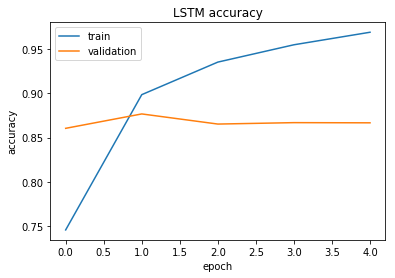

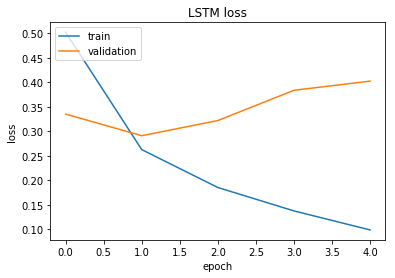

In [38]:
plot_accuracy(lstm_history, 'LSTM accuracy')
plot_loss(lstm_history, 'LSTM loss')

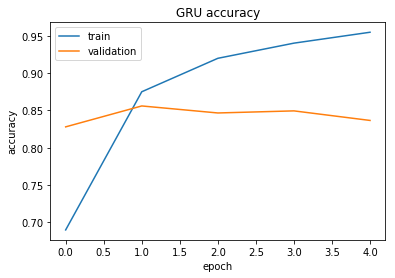

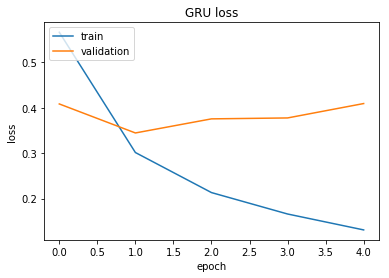

In [39]:
plot_accuracy(gru_history, 'GRU accuracy')
plot_loss(gru_history, 'GRU loss')


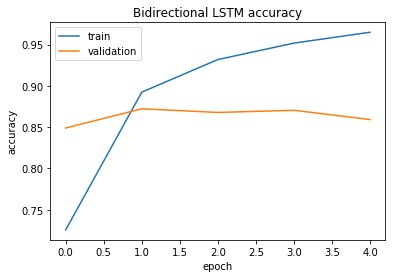

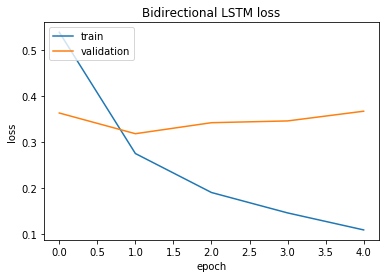

In [40]:
plot_accuracy(bilstm_history, 'Bidirectional LSTM accuracy')
plot_loss(bilstm_history, 'Bidirectional LSTM loss')


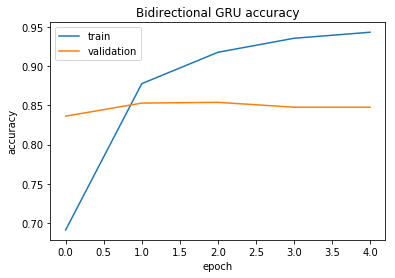

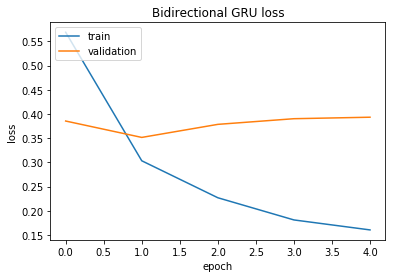

In [41]:
plot_accuracy(bigru_history, 'Bidirectional GRU accuracy')
plot_loss(bigru_history, 'Bidirectional GRU loss')

In [42]:
## create pandas table
[lstm_uvalid_loss, lstm_uvalid_acc] = lstm_model.evaluate(X_unseen_validation, y_unseen_validation)
[gru_uvalid_loss, gru_uvalid_acc] = gru_model.evaluate(X_unseen_validation, y_unseen_validation)
[bilstm_uvalid_loss, bilstm_uvalid_acc] = bilstm_model.evaluate(X_unseen_validation, y_unseen_validation)
[bigru_uvalid_loss, bigru_uvalid_acc] = bigru_model.evaluate(X_unseen_validation, y_unseen_validation)


5000/5000 [==============================] - 22s 4ms/step


In [43]:
tdata = {'loss': pd.Series([lstm_uvalid_loss, gru_uvalid_loss, bilstm_uvalid_loss, bigru_uvalid_loss],
                           index=['lstm', 'gru', 'bi-lstm', 'bi-gru']),
        'accuracy': pd.Series([lstm_uvalid_acc, gru_uvalid_acc, bilstm_uvalid_acc, bigru_uvalid_acc],
                              index=['lstm', 'gru', 'bi-lstm', 'bi-gru'])}
uvalid_df = pd.DataFrame(tdata)


#### Present table comparison of model performance

In [44]:
print("Accuracy and loss for models using unseen validation data: \n")
print(uvalid_df)

Accuracy and loss for models using unseen validation data: 

         accuracy      loss
lstm       0.8656  0.418393
gru        0.8446  0.402031
bi-lstm    0.8534  0.372993
bi-gru     0.8524  0.391824


Because the validation sets were used to optmize the parameters for each one of the four trained models, we cannot use those values to determine which model has the best performance. Hence, we use an set of unseen validation data to compare the accuracy obtained by each of the four trained models. From these results we select our best RNN architecture. According to the values shown above, the LSTM model has the best performance. We use this model for the rest of the assignment. 

Due to the models having similar accuracy values, the best model could change if we run the procedure several times.

### 3. Feature extraction

#### Tasks: 

* Choose one model with the best performance and use the model to produce ”neural codes” (document embedding) of raw text (5000 instances of unseen validation set) from RNN layer.
*  Use tSNE to reduce the dimension of extracted text features (encoded version of 5000 documents) into two (2) dimensions and visualize it towards their sentiment labels.


In [45]:
# load the trained model
from keras.models import load_model

# YOUR CODE HERE
# choose the best model

model = load_model('lstm_model.h5')
model.load_weights('weights_lstm_model.hdf5')
model_encoder = Model(inputs=model.input, outputs=model.get_layer("word_embedding").output)


#### Produce Neural codes of text reviews

In [46]:
# YOUR CODE HERE
# generate "neural codes" (document embedding) from the model
doc_embedding = model_encoder.predict(X_test)

In [47]:
from sklearn.decomposition import PCA

dimData = np.prod(doc_embedding.shape[1:])
doc_embedding_flat = doc_embedding.reshape((doc_embedding.shape[0], -1))
doc_embedding_flat.shape

(5000, 72000)

In [48]:
pca = PCA(n_components=500)
pca.fit(doc_embedding_flat)
reduced_doc_embedding = pca.transform(doc_embedding_flat)

print(doc_embedding.shape)
print(dimData)
#print(doc_embedding[0])
print(doc_embedding_flat.shape)
print(reduced_doc_embedding.shape)

(5000, 600, 120)
72000
(5000, 72000)
(5000, 500)


### PCA transform explanation

For each sequence we extract its neural codes using the embedding layer obtained from the training procedure. The neural codes obtained have a large dimensionality because they are a sequence of 600 words represented as embeddings. If we apply the tSNE transformation on these neural codes the tSNE algorithm performs bad. As recommended by [Laurens van der Maaten](https://lvdmaaten.github.io/tsne/#faq) we apply PCA first to reduce the dimensionality of the neural codes and then apply tSNE.


#### tSNE visualization

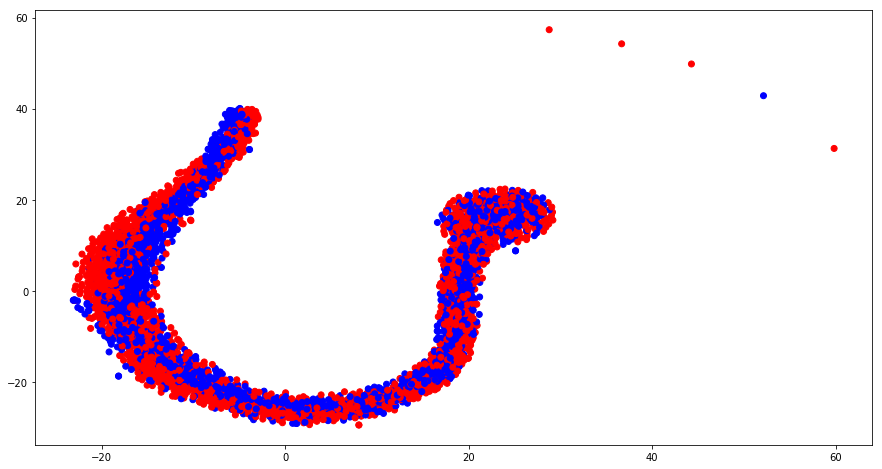

In [49]:
# YOUR CODE HERE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

color_names = ["red", "blue"]
colors = []
for label in y_test:
    # negative label
    if label == 0:
        colors.append("red")
    # positive label
    else:
        colors.append("blue")

# use tSNE to plot document embedding on its sentiment label
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_test_projection = tsne.fit_transform(reduced_doc_embedding).T
fig = plt.figure(figsize=(15, 8))
plt.scatter(X_test_projection[0],
            X_test_projection[1],
            c=colors)
plt.show()

### tSNE visualization description

The reduced neural codes are plotted in the image shown above using a tNSE transformation. Negative sentences are shown as red dots and positive sentences as blue dots. From the figure we observe that there is not a clear distinction between positive and negative sentences. This could be caused by a lot of distortion introduced in the 2d vector after applying two dimensionality reduction techniques to convert a sequence of 600 vectors with 120 dimensions to a 2d vector.

We also tried applying the tSNE directly, without using a PCA reduction first, and the results were similar, but the time to compute the tSNE transformantion increased from several minutes to several hours.

### 4. One shot learning on multi-class classification

#### Tasks: 

* Use the RNN model that has been trained on binary classification task to extract features from different data set (Amazon product reviews)
* Define and implement an approach to assign labels on unlabelled set of reviews, by using the concept of "one shot learning"
* Compute accuracy, given ground truth labels
* Discuss the results 

Explain how the approach works.


#### Answer:

Our one shot learning procedure works as follows:
* We use the embedding layer to obtain vector representations of our labeled and unlabeled amazon product reviews. We expect that the embedding layer is able to produce good representations because it was trained on another review dataset.
* Using the euclidean distance we compare each unlabeled review against each labeled review. Each unlabel review is assigned a label corresponding to the most similar labeled review.
* The euclidean distance is used instead of the cosine similarity because for the latter we can obtain negative similarity values, which don't make much sense considering that the embeddings represent text information.

If we add more unlabeled examples or labeled ones, this procedure still works without the need of retraining anything.

In [50]:
# load datasets
amazon_labelled_data = pd.read_csv(os.path.join(DATA_PATH,"example1_labelled.tsv"), header=0, delimiter="\t")
amazon_unlabelled_data = pd.read_csv(os.path.join(DATA_PATH,"example2_unlabelled.tsv"), header=0, delimiter="\t")
print(amazon_labelled_data)
print(amazon_unlabelled_data)

         label                                             review
0       camera  My husband bought this camera about 3 months a...
1       laptop  I got this notebook several months ago and I'v...
2  mobilephone  I have this phone for about 10 months.  The ca...
                                              review
0  I purchased the 20d in Feb 2011, around 7 year...
1  It's been 3 weeks now and I've only had minor ...
2  I purchased this Z Series laptop about 5 month...
3  When I first got this laptop (at a garage sale...
4  I love this phone. I've had my own for over a ...
5  I purchased this camera to replace my Casio EX...
6  My perfect camera has to do two things very we...


In [51]:
# process datasets
amazon_train_docs = []
amazon_labels_dict = {}
amazon_train_labels = []
i = 0
for cont, label in zip(amazon_labelled_data.review, amazon_labelled_data.label):
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    amazon_train_docs.append(doc)
    amazon_labels_dict[i] = label
    amazon_train_labels.append(i)
    i+=1
    
print(amazon_labels_dict)
    
amazon_test_docs =[]
amazon_test_labels = []
for cont in amazon_unlabelled_data.review:
    doc = clean(striphtml(cont))
    doc = doc.lower() 
    amazon_test_docs.append(doc)
    
# create tokens
amazon_train_str_tokens = []
for text in amazon_train_docs:
    amazon_train_str_tokens.append(tokenizeWords(text))
    
amazon_test_str_tokens = []
for text in amazon_test_docs:
    amazon_test_str_tokens.append(tokenizeWords(text))

    
# create list of list of numeric tokens
amazon_train_int_input = []
for i, text in enumerate(amazon_train_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    amazon_train_int_input.append(int_tokens)

amazon_test_int_input = []
for i, text in enumerate(amazon_test_str_tokens):
    int_tokens = [indices_words[w] if w in indices_words.keys() else indices_words['<unk>'] for w in text ]
    amazon_test_int_input.append(int_tokens)
    

## represent training and test sets as arrays
from keras.utils.np_utils import to_categorical
X_amazon_train_arr = np.array(amazon_train_int_input)
y_amazon_train = to_categorical(np.array(amazon_train_labels))
#print(y_amazon_train)
X_amazon_test_arr = np.array(amazon_test_int_input)
#y_amazon_test = np.array()

## Apply padding to the sequences
from keras.preprocessing import sequence

X_amazon_train = sequence.pad_sequences(X_amazon_train_arr, maxlen=MAX_REVIEW_LENGTH, value=0)
X_amazon_test = sequence.pad_sequences(X_amazon_test_arr, maxlen=MAX_REVIEW_LENGTH, value=0)


{0: 'camera', 1: 'laptop', 2: 'mobilephone'}


In [52]:
from keras.models import load_model
from keras.layers import Embedding, Input, LSTM, Dense, GRU, Bidirectional
from keras.models import Model

#num_epochs = 15

## load best model
model = load_model('lstm_model.h5')
model.load_weights('weights_lstm_model.hdf5')
## Select part of the model
model_encoder = Model(inputs=model.input, outputs=model.get_layer("lstm_layer").output)
## Add dense layer to the model

amazon_train_encoding = model_encoder.predict(X_amazon_train)
amazon_test_encoding = model_encoder.predict(X_amazon_test)


In [61]:
# from sklearn.metrics.pairwise import cosine_similarity
# 
from sklearn.metrics.pairwise import euclidean_distances

train_info = []
for i, element in enumerate(amazon_train_encoding):
    label = amazon_labels_dict[i]
    train_info.append((element, label))
#print(train_info)

test_reviews_labels = []
for encoded_test_review in amazon_test_encoding:
    label = None
    distance = 0.0
    for element in train_info:
        encoded_train_review = element[0]
        element_label = element[1]
        #print(encoded_test_review)
        #print(encoded_test_review.reshape(1, -1))
        #print(encoded_train_review)
        current_distance = euclidean_distances(encoded_test_review.reshape(1, -1), encoded_train_review.reshape(1, -1))
        #print(current_distance)
        if label == None:
            distance = current_distance
            label = element_label
        if current_distance < distance:
            label = element_label
            distance = current_distance
            
    test_reviews_labels.append(label)

print(test_reviews_labels)


['laptop', 'camera', 'mobilephone', 'camera', 'mobilephone', 'camera', 'mobilephone']


In [62]:
print(amazon_unlabelled_data.review[0][:200])
print(amazon_unlabelled_data.review[1][:200])
print(amazon_unlabelled_data.review[2][:200])
print(amazon_unlabelled_data.review[3][:200])
print(amazon_unlabelled_data.review[4][:200])
print(amazon_unlabelled_data.review[5][:200])
print(amazon_unlabelled_data.review[6][:200])
#print(amazon)

I purchased the 20d in Feb 2011, around 7 years after it was first introduced. The camera was so good built that it looked like new and seemed like it will last another 5 years. I bought it for less t
It's been 3 weeks now and I've only had minor voice mail setup issues.  The phone itself is the best I've had in years.  Clear calls and it gets signals where my previous AT&T service would not.  My g
I purchased this Z Series laptop about 5 months ago, its my first Sony laptop, Im a Mac fan, but not any more I guess... I gave my sister my macbook pro, and the change has been great. I was looking f
When I first got this laptop (at a garage sale, broken) It was really slow and leggy so I installed Linux Mint.  Right away I noticed a huge difference but it was still not fast enough to be my daily 
I love this phone. I've had my own for over a year now and have since bought one for my son and for my daughter. Battery life is excellent, more features that I could dream of using. The phone cam

From the one-shot learning procedure and the the text in the reviews we obtain the following information:
* The first sentence is assigned label __laptop__, and it's label should be __camera__.
* The second sentence is assigned label __camera__, and it's label should be __mobilephone__.
* The third sentence is assigned label __mobilephone__, and it's label should be __laptop__.
* The fourth sentence is assigned label __camera__, and it's label should be __laptop__.
* The fifth sentence is assigned label __mobilephone__, and it's label should be __mobilephone__.
* The sixth sentence is assigned label __camera__, and it's label should be __camera__.
* The seventh sentence is assigned label __mobilephone__, and it's label should be __camera__.

Therefore, the overall accuracy for our one shot learning approach is 2/7

Discuss the result. Why it works -- or why it does not work.

#### Answer:

Our one-shot learning procedure doesn't seem to work. We think this happens because instead of learning a distance metric  for the one-shot learning procedure, we used a generic distance metric and the embeddings obtained from our LSTM model. Also, the movies reviews are different than the amazon reviews. When trying to apply transfern learning, we are limited to the amount of reviews used to train our model, which is a very small dataset compared to other used to obtain embeddings like the Glove datasets.